In [1]:
%config Completer.use_jedi = False

In [2]:
import copy
import json
import random
from collections import defaultdict, deque
from typing import Sequence

import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam, lr_scheduler

In [3]:
EMPTY_MOVE = (-1, -1)

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win, clone=None):
        self.gameOver = False
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([self.board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([self.board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----' * self.n_cols + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * self.n_cols + '-')

    def getState(self):
        return self.getHash(), self.getEmptySpaces(), self.curTurn

    def action_from_int(self, action_int):
        return int(action_int / self.n_cols), int(action_int % self.n_cols)

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action: Sequence[int]):
        if self.board[action[0], action[1]] != 0:
            self.curTurn = -self.curTurn
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
class AgentQ:
    def __init__(self, alpha=0.05, gamma=0.9):
        self.alpha = alpha
        self.gamma = gamma
        self.q = defaultdict(dict)

    @staticmethod
    def state_to_int(state):
        return int(''.join(['%s' % (x + 1) for x in state.ravel()]), 3)

    @staticmethod
    def get_empty_spaces(state, done):
        res = np.where(state == 0)
        if len(res[0]) == 0 or done:
            return [EMPTY_MOVE]
        else:
            return [(i, j) for i, j in zip(res[0], res[1])]

    def get_policy(self):
        policy = {}
        for state, action_dict in self.q.items():
            best_action = max(action_dict.items(), key=lambda x: x[1])[0]
            policy[state] = best_action
        return policy

    def init_q(self, state, empty_spaces):
        if state not in self.q:
            actions = [tuple(map(int, action)) for action in empty_spaces]
            self.q[state] = {action: np.float16(np.random.random()) for action in actions}

    def act(self, state):
        empty_spaces = self.get_empty_spaces(state, False)
        state = self.state_to_int(state)
        self.init_q(state, empty_spaces)
        return max(self.q[state].items(), key=lambda x: x[1])[0]

    def update(self, state, action, next_state, reward, done):
        empty_spaces = self.get_empty_spaces(state, False)
        state = self.state_to_int(state)
        self.init_q(state, empty_spaces)
        if next_state is None:
            self.q[state][action] = reward
        else:
            empty_spaces = self.get_empty_spaces(next_state, done)
            next_state = self.state_to_int(next_state)
            if done:
                next_state_value = 0
            else:
                self.init_q(next_state, empty_spaces)
                next_state_value = max(self.q[next_state].values())
            self.q[state][action] = self.q[state][action] + self.alpha * (
                reward
                + self.gamma * next_state_value
                - self.q[state][action]
            )

In [6]:
class Trainer:
    def __init__(self, env: TicTacToe, agent_cross, agent_zero, epsilon=0.2):
        self.env = env
        self.agent_cross = agent_cross
        self.agent_zeros = agent_zero
        self.epsilon = epsilon
        self.cross_s = None
        self.cross_a = None
        self.zeros_s = None
        self.zeros_a = None
        self.prime_cross_s = None
        self.prime_cross_a = None
        self.prime_zeros_s = None
        self.prime_zeros_a = None
        self.done = False
        self.reward_zeros = 0
        self.reward_cross = 0
        self.cur_turn = 1

    def reset(self):
        self.env.reset()
        self.done = False
        self.cross_s = self.env.board.copy()
        self.cross_a = self.agent_cross.act(self.env.board)
        self.zeros_s = None
        self.zeros_a = None
        self.prime_cross_s = None
        self.prime_zeros_s = None
        self.prime_cross_a = None
        self.prime_zeros_a = None
        self.reward_zeros = 0
        self.reward_cross = 0
        self.cur_turn = 1

    def set_action(self):
        if self.cur_turn == 1:
            self.prime_cross_a = self.cross_a
            if self.done:
                self.cross_a = EMPTY_MOVE
            elif random.random() > self.epsilon:
                self.cross_a = self.agent_cross.act(self.cross_s)
            else:
                self.cross_a = tuple(random.choice(self.env.getEmptySpaces()))
        else:
            self.prime_zeros_a = self.zeros_a
            if self.done:
                self.zeros_a = EMPTY_MOVE
            elif random.random() > self.epsilon:
                self.zeros_a = self.agent_zeros.act(self.zeros_s)
            else:
                self.zeros_a = tuple(random.choice(self.env.getEmptySpaces()))

    def parse_reward(self, reward):
        self.reward_cross = reward
        self.reward_zeros = -reward
        if reward == -10:
            if self.cur_turn == 1:
                self.reward_cross = 0
                self.reward_zeros = -10
            else:
                self.reward_cross = -10
                self.reward_zeros = 0

    def env_step(self):
        if self.cur_turn == 1:
            self.prime_zeros_s = self.zeros_s
            _, reward, self.done, _ = self.env.step(self.cross_a)
            self.cur_turn = self.env.curTurn
            self.zeros_s = self.env.board.copy()
            self.set_action()
            self.parse_reward(reward)
            if self.prime_zeros_s is not None and self.prime_zeros_a is not None:
                self.agent_zeros.update(
                    self.prime_zeros_s,
                    self.prime_zeros_a,
                    self.zeros_s,
                    self.reward_zeros,
                    self.done,
                )
            if self.done:
                self.agent_cross.update(
                    self.cross_s, self.cross_a, None, self.reward_cross, self.done
                )
        else:
            self.prime_cross_s = self.cross_s
            _, reward, self.done, _ = self.env.step(self.zeros_a)
            self.cur_turn = self.env.curTurn
            self.cross_s = self.env.board.copy()
            self.set_action()
            self.parse_reward(reward)
            if self.prime_cross_a is not None:
                self.agent_cross.update(
                    self.prime_cross_s,
                    self.prime_cross_a,
                    self.cross_s,
                    self.reward_cross,
                    self.done,
                )
            if self.done:
                self.agent_zeros.update(
                    self.zeros_s, self.zeros_a, None, self.reward_zeros, self.done
                )

    def evaluate_policy(self):
        cross_rewards = []
        zeros_rewards = []
        for i in range(1000):
            self.reset()
            done = False
            reward = 0
            while not done:
                if self.env.curTurn == 1:
                    state_c = self.env.board
                    action_c = self.agent_cross.act(state_c)
                    _, reward, done, _ = self.env.step(action_c)
                else:
                    action_z = random.choice(self.env.getEmptySpaces())
                    _, reward, done, _ = self.env.step(action_z)
            self.parse_reward(reward)
            cross_rewards.append(self.reward_cross)
            self.reset()
            done = False
            while not done:
                if self.env.curTurn == -1:
                    state_z = self.env.board
                    action_z = self.agent_zeros.act(state_z)
                    _, reward, done, _ = self.env.step(action_z)
                else:
                    action_c = random.choice(self.env.getEmptySpaces())
                    _, reward, done, _ = self.env.step(action_c)
            self.parse_reward(reward)
            zeros_rewards.append(self.reward_zeros)
        return np.mean(cross_rewards), np.mean(zeros_rewards)

    def train(self, iterations):
        rewards_cross = []
        rewards_zeros = []
        iters = []
        for i in range(iterations):
            self.reset()

            while not self.done:
                self.env_step()
            if (i + 1) % 5000 == 0:
                mean_cross_reward, mean_zeros_reward = self.evaluate_policy()
                rewards_cross.append(mean_cross_reward)
                rewards_zeros.append(mean_zeros_reward)
                iters.append(i + 1)
                if (i + 1) % 20000 == 0:
                    print(f"Iter {i + 1}/{iterations}, cross reward: {mean_cross_reward}, zeros reward {mean_zeros_reward}")
        return iters, rewards_cross, rewards_zeros

# Часть 1

## 1.1 - Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3. 

Iter 20000/100000, cross reward: 0.977, zeros reward 0.407
Iter 40000/100000, cross reward: 0.918, zeros reward 0.597
Iter 60000/100000, cross reward: 0.962, zeros reward 0.783
Iter 80000/100000, cross reward: 0.987, zeros reward 0.833
Iter 100000/100000, cross reward: 0.983, zeros reward 0.814


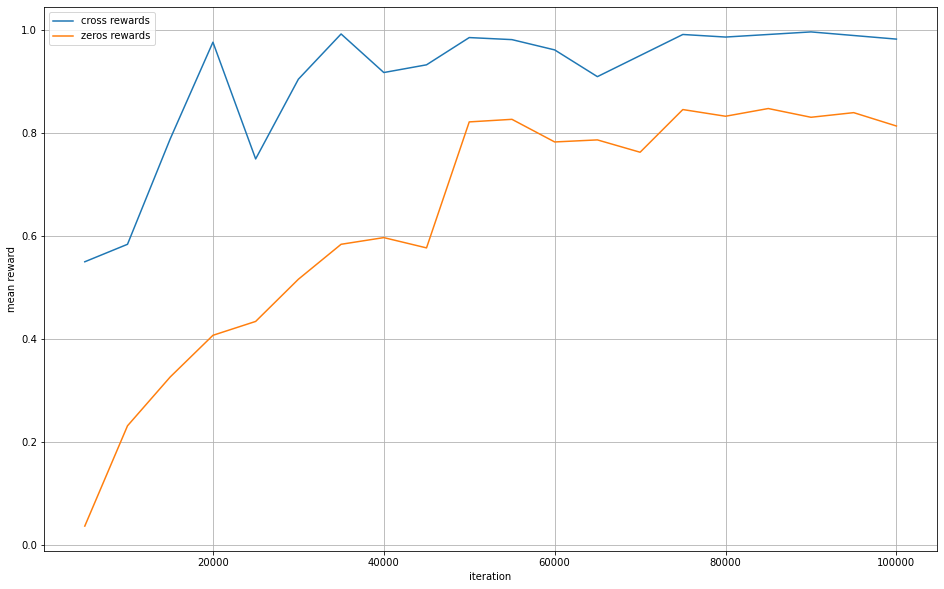

In [7]:
N_COLS, N_ROWS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentQ()
agent_zeros = AgentQ()
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(100_000)

with open(f"{N_ROWS}_q_policy_cross.json", "w") as f:
    json.dump(agent_cross.get_policy(), f)
with open(f"{N_ROWS}_q_policy_zeros.json", "w") as f:
    json.dump(agent_zeros.get_policy(), f)
    
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

## 1.2 - Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Iter 20000/3000000, cross reward: 0.076, zeros reward -0.06
Iter 40000/3000000, cross reward: 0.046, zeros reward -0.03
Iter 60000/3000000, cross reward: -0.014, zeros reward -0.006
Iter 80000/3000000, cross reward: 0.122, zeros reward -0.016
Iter 100000/3000000, cross reward: 0.026, zeros reward -0.05
Iter 120000/3000000, cross reward: -0.001, zeros reward -0.062
Iter 140000/3000000, cross reward: 0.122, zeros reward -0.046
Iter 160000/3000000, cross reward: 0.132, zeros reward -0.061
Iter 180000/3000000, cross reward: 0.131, zeros reward -0.066
Iter 200000/3000000, cross reward: -0.027, zeros reward -0.001
Iter 220000/3000000, cross reward: 0.056, zeros reward -0.032
Iter 240000/3000000, cross reward: 0.165, zeros reward -0.075
Iter 260000/3000000, cross reward: 0.14, zeros reward -0.01
Iter 280000/3000000, cross reward: 0.148, zeros reward -0.024
Iter 300000/3000000, cross reward: 0.077, zeros reward -0.047
Iter 320000/3000000, cross reward: 0.046, zeros reward -0.027
Iter 340000/30

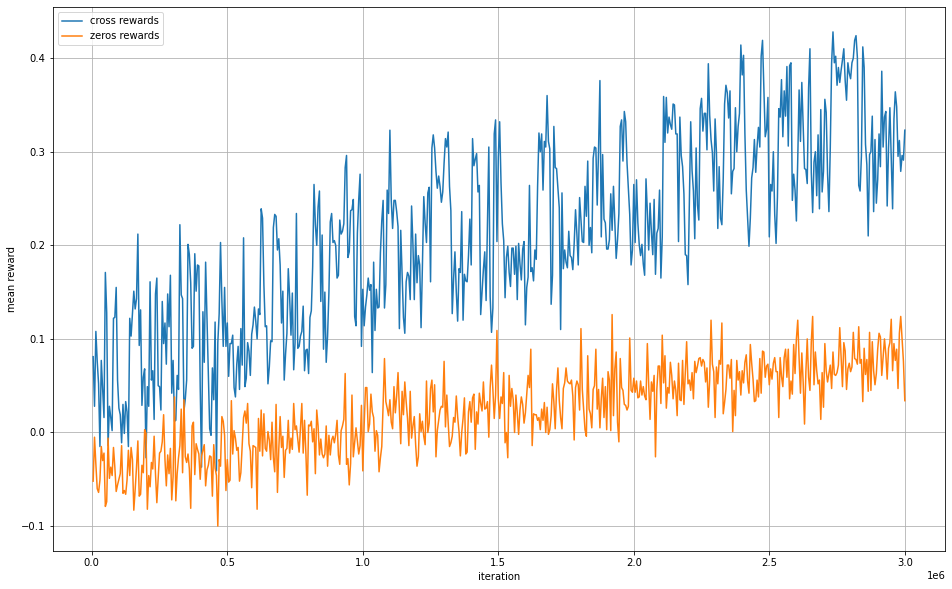

In [8]:
N_COLS, N_ROWS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentQ()
agent_zeros = AgentQ()
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(3_000_000)

with open(f"{N_ROWS}_q_policy_cross.json", "w") as f:
    json.dump(agent_cross.get_policy(), f)
with open(f"{N_ROWS}_q_policy_zeros.json", "w") as f:
    json.dump(agent_zeros.get_policy(), f)
    
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

# Часть 2

## 2.1 - Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов

In [9]:
class QModel(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(1, 1)),
        )
        self.head = nn.Linear(state_dim * 16, state_dim)

    def forward(self, x):
        x = self.fc(x).view(x.shape[0], -1)
        return self.head(x)

    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.xavier_uniform_(m.weight)

In [10]:
class ExpirienceReplay(deque):
    def sample(self, size):
        batch = random.choices(self, k=size)
        return list(zip(*batch))

In [11]:
class AgentDQN:
    def __init__(
        self,
        state_dim,
        gamma=0.99,
        buffer_size=128_000,
        learning_rate=1e-3,
        device="cuda",
        batch_size=128,
        initial_steps=1024,
        steps_per_update=4
    ):
        self.steps = 0
        self.device = device
        self.gamma = gamma
        self.batch_size = batch_size
        self.initial_steps = initial_steps
        self.steps_per_update = steps_per_update
        self.model = QModel(state_dim).to(device)
        self.buffer = ExpirienceReplay(maxlen=buffer_size)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.criteria = nn.MSELoss()
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = self.buffer.sample(self.batch_size)
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done

    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        self.optimizer.zero_grad()
        state, action, next_state, reward, done = batch
        current_q = self.model(state.to(self.device))
        next_q = self.model(next_state.to(self.device))
        next_action = torch.argmax(next_q, 1)
        next_target_q = self.model(next_state.to(self.device))
        action_reward = current_q.gather(1, action.view(-1, 1).to(self.device))
        next_actions_reward = next_target_q.gather(1, next_action.view(-1, 1))
        next_actions_reward = next_actions_reward.squeeze(1) * (
            1 - done.to(self.device)
        )
        loss = self.criteria(
            action_reward.squeeze(1),
            reward.to(self.device) + self.gamma * next_actions_reward,
        )
        loss.backward()
        self.optimizer.step()
        if self.steps > 1_000_000:
            self.scheduler.step(loss)

    def act(self, state):
        if self.model.training:
            self.model.eval()
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        action_rewards = self.model(state).detach().cpu().numpy()
        index = np.argmax(action_rewards.squeeze())
        return index // state.shape[-1], index % state.shape[-1]

    def update(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)

Iter 20000/100000, cross reward: 0.973, zeros reward 0.508
Iter 40000/100000, cross reward: 0.987, zeros reward 0.674
Iter 60000/100000, cross reward: 0.987, zeros reward 0.608
Iter 80000/100000, cross reward: 0.985, zeros reward 0.566
Iter 100000/100000, cross reward: 0.975, zeros reward 0.162


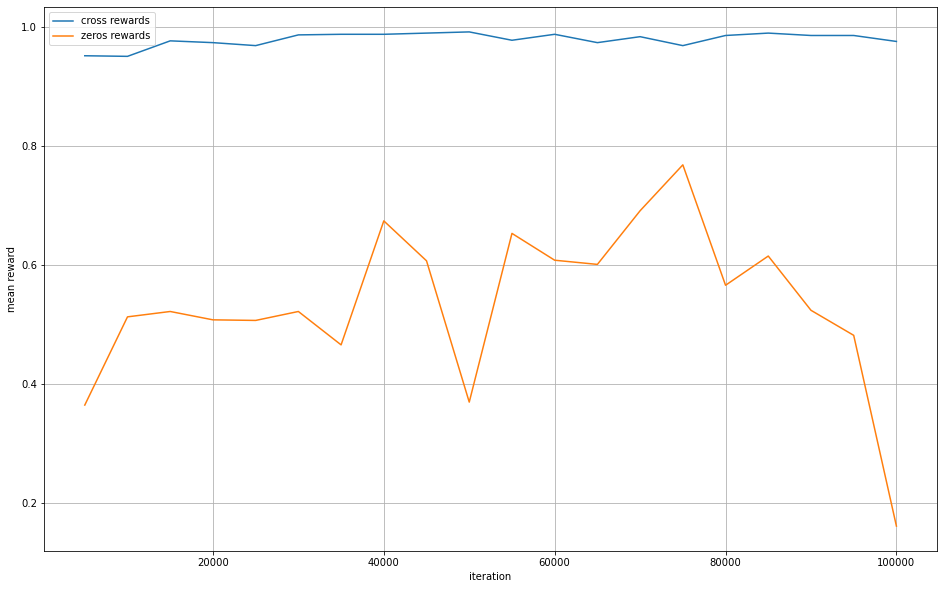

In [12]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(100_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iter 20000/50000, cross reward: 0.877, zeros reward 0.571
Iter 40000/50000, cross reward: 0.707, zeros reward 0.626


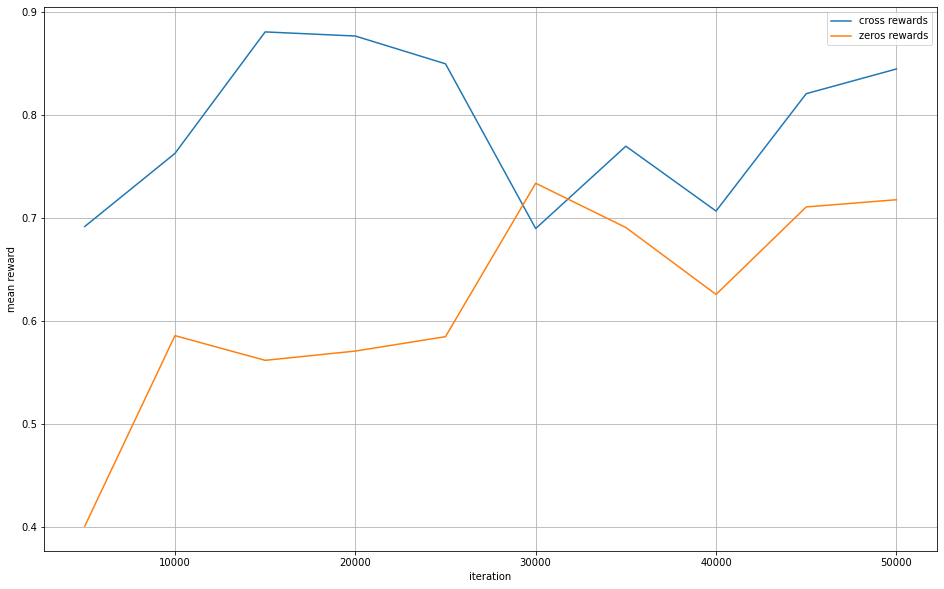

In [13]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iter 20000/50000, cross reward: 0.526, zeros reward 0.335
Iter 40000/50000, cross reward: 0.688, zeros reward 0.422


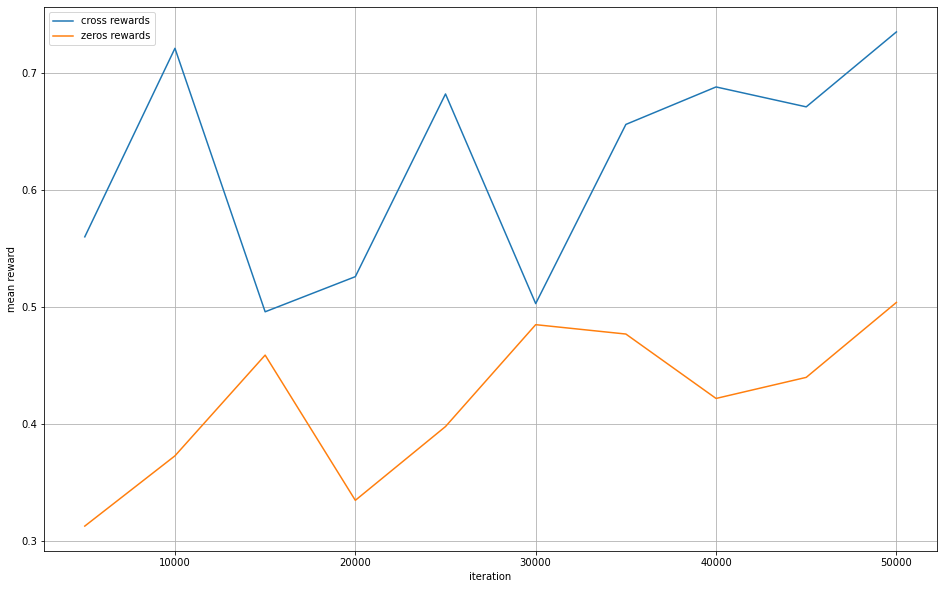

In [14]:
N_ROWS, N_COLS, N_WINS = 5, 5, 5

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

## 2.2 Реализуйте Double DQN и/или Dueling DQN.

In [15]:
class AgentDDQN:
    def __init__(
        self,
        state_dim,
        gamma=0.99,
        buffer_size=128_000,
        learning_rate=1e-3,
        device="cuda",
        batch_size=128,
        initial_steps=1024,
        steps_per_update=4,
        steps_per_target_update=4000,
    ):
        self.steps = 0  # Do not change
        self.device = device
        self.gamma = gamma
        self.batch_size = batch_size
        self.initial_steps = initial_steps
        self.steps_per_update = steps_per_update
        self.steps_per_target_update = steps_per_target_update
        self.model = QModel(state_dim).to(device)  # Torch model
        self.target_model = QModel(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.buffer = ExpirienceReplay(maxlen=buffer_size)
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.criteria = nn.MSELoss()
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10000, gamma=0.8)

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch = self.buffer.sample(self.batch_size)
        state, action, next_state, reward, done = batch
        state = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(1)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.tensor(np.array(next_state, dtype=np.float32)).unsqueeze(1)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.int32))
        return state, action, next_state, reward, done

    def train_step(self, batch):
        if not self.model.training:
            self.model.train()
        self.optimizer.zero_grad()
        state, action, next_state, reward, done = batch
        current_q = self.model(state.to(self.device))
        next_q = self.model(next_state.to(self.device))
        next_action = torch.argmax(next_q, 1)
        with torch.no_grad():
            next_target_q = self.target_model(next_state.to(self.device))
        action_reward = current_q.gather(1, action.view(-1, 1).to(self.device))
        next_actions_reward = next_target_q.gather(1, next_action.view(-1, 1))
        next_actions_reward = next_actions_reward.squeeze(1) * (
            1 - done.to(self.device)
        )
        loss = self.criteria(
            action_reward.squeeze(1),
            reward.to(self.device) + self.gamma * next_actions_reward,
        )
        loss.backward()
        self.optimizer.step()
        if self.steps > 1_000_000:
            self.scheduler.step(loss)

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

    def act(self, state):
        if self.model.training:
            self.model.eval()
        state = torch.tensor(np.array(state)).view(1, 1, state.shape[-2], state.shape[-1])
        state = state.float().to(self.device)
        action_rewards = self.model(state).detach().cpu().numpy()
        index = int(np.argmax(action_rewards.squeeze()))
        return index // state.shape[-1], index % state.shape[-1]

    def update(self, state, action, next_state, reward, done):
        if next_state is None:
            next_state = state
        action = action[0] * state.shape[-1] + action[1]
        self.consume_transition((state, action, next_state, reward, done))
        self.steps += 1
        if self.steps > self.initial_steps:
            if self.steps % self.steps_per_update == 0:
                batch = self.sample_batch()
                self.train_step(batch)
            if self.steps % self.steps_per_target_update == 0:
                self.update_target_network()

Iter 20000/50000, cross reward: 0.986, zeros reward 0.751
Iter 40000/50000, cross reward: 0.983, zeros reward 0.865


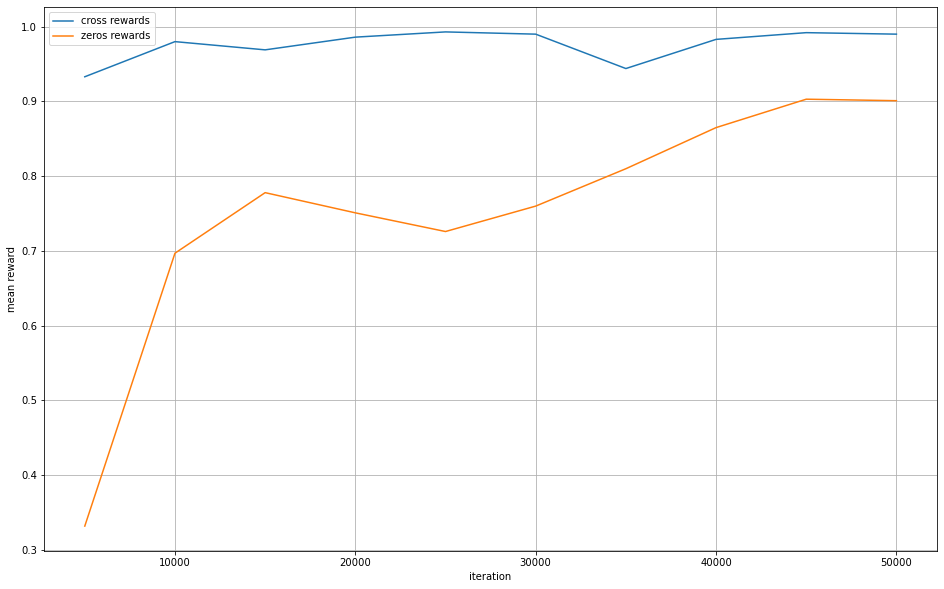

In [16]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iter 20000/50000, cross reward: 0.927, zeros reward 0.847
Iter 40000/50000, cross reward: 0.937, zeros reward 0.789


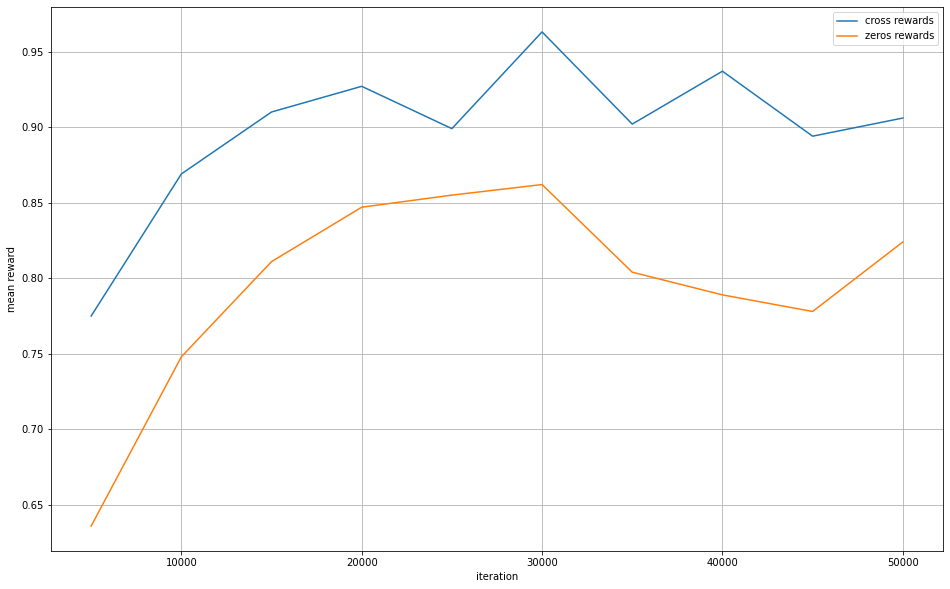

In [17]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iter 20000/50000, cross reward: 0.76, zeros reward 0.567
Iter 40000/50000, cross reward: 0.703, zeros reward 0.829


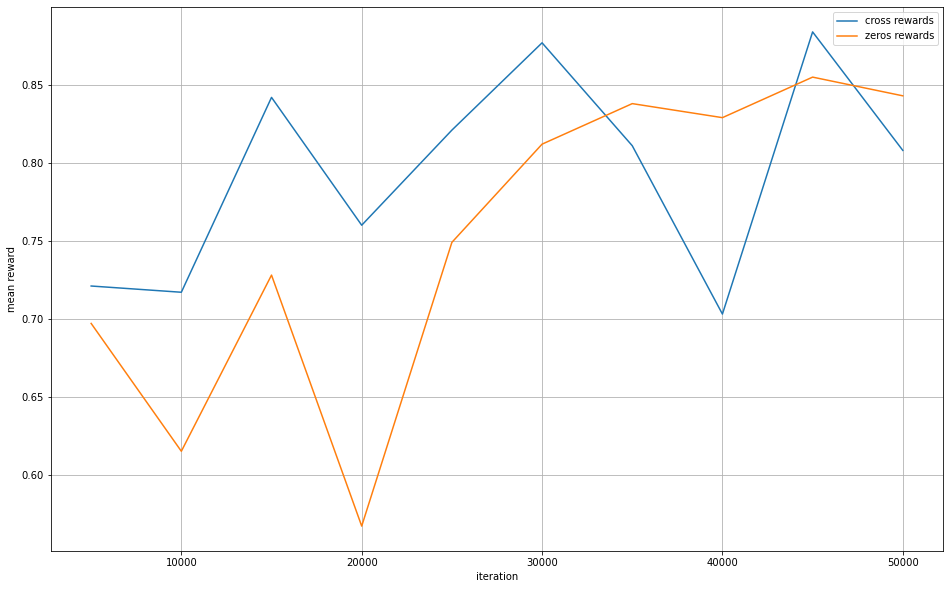

In [18]:
N_ROWS, N_COLS, N_WINS = 5, 5, 5

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
agent_cross = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
agent_zeros = AgentDDQN(N_ROWS * N_COLS, device="cuda:1")
trainer = Trainer(env, agent_cross, agent_zeros)
iterations, rewards_cross, rewards_zeros = trainer.train(50_000)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

# Часть 3

## 3.1 -Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [19]:
# пустая политика даст случайный rollout

def rollout(env, policy_cross, policy_zeros):
    reward = 0
    done = False
    clone_env = TicTacToe(3, 3, 3, clone=env)
    while not done:
        state = state_to_int(env.board)
        if env.curTurn == 1 and state in policy_cross:
            move = policy_cross[state]
        elif env.curTurn == 0 and state in policy_zeros:
            move = policy_zeros[state]
        else:
            move = random.choice(clone_env.getEmptySpaces())
        _, reward, done, _ = clone_env.step(move)
    return reward

## 3.2 - Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [20]:
class Node:
    def __init__(self, move=None, parent=None, empty_spaces=None, turn=None, c=2):
        self.move = move
        self.parentNode = parent
        self.childNodes = {}
        self.wins = 0
        self.visits = 0
        self.c = c
        self.untriedMoves = list(map(tuple, empty_spaces))
        self.turn = turn

    def utc(self, node, visits):
        return node.wins / node.visits + self.c * np.sqrt(2 * np.log(visits) / node.visits)

    def utc_select_child(self):
        s = max(self.childNodes.values(), key=lambda x: self.utc(x, self.visits))
        return s

    def random_select(self):
        s = random.choice(list(self.childNodes.values()))
        return s

    def add_child(self, move, empty_spaces, turn):

        node = Node(
            move=move,
            parent=self,
            empty_spaces=empty_spaces,
            turn=turn,
        )
        self.untriedMoves.remove(move)
        self.childNodes[move] = node
        return node

    def update(self, result):
        self.visits += 1
        self.wins += result * self.turn

    def update_untried_moves(self, state, empty_spaces):
        if state not in self.untriedMoves:
            self.untriedMoves[state] = list(map(tuple, empty_spaces))

In [21]:
def state_to_int(state):
    return int(''.join(['%s' % (x + 1) for x in state.ravel()]), 3)


def get_empty_spaces(state, done):
    res = np.where(state == 0)
    if len(res[0]) == 0 or done:
        return []
    else:
        return [(i, j) for i, j in zip(res[0], res[1])]

In [22]:
def simulate_games(env, policy, turn, iterations=1000):
    env = TicTacToe(3, 3, 3, clone=env)
    rewards = []
    root = policy
    for _ in range(iterations):
        reward = 0
        env.reset()
        done = False
        policy_exists = True
        policy = root
        while not done:
            if env.curTurn == turn and len(policy.childNodes) > 0 and policy_exists:
                policy = max(policy.childNodes.values(), key=lambda x: x.wins / x.visits)
                _, reward, done, _ = env.step(policy.move)
            elif env.curTurn == turn:
                move = random.choice(get_empty_spaces(env.board, env.gameOver))
                _, reward, done, _ = env.step(move)
            else:
                move = random.choice(get_empty_spaces(env.board, env.gameOver))
                _, reward, done, _ = env.step(move)
                if move in policy.childNodes:
                    policy = policy.childNodes[move]
                else:
                    policy_exists = False
        rewards.append(reward)
    return np.mean(rewards)

In [23]:
def train_mcts(env: TicTacToe, itermax, policy_cross, policy_zeros):

    rootnode = Node(empty_spaces=env.getEmptySpaces(), turn=0)
    cross_rewards = []
    zeros_rewards = []
    iterations = []
    log_step = itermax // 10
    for i in range(itermax):
        reward = 0
        done = False
        env.reset()
        node = rootnode

        # select leaf
        while len(node.untriedMoves) == 0 and len(node.childNodes) > 0:
            node = node.utc_select_child()
            _, reward, done, _ = env.step(node.move)

        # expand leaf
        if len(node.untriedMoves) > 0:
            move = random.choice(node.untriedMoves)
            cur_turn = env.curTurn
            _, reward, done, _ = env.step(move)
            node = node.add_child(
                move=move,
                empty_spaces=get_empty_spaces(env.board, env.gameOver),
                turn=cur_turn
            )

        # rollout
        if not done:
            reward = rollout(env, policy_cross, policy_zeros)

        # backprop
        while node is not None:
            node.update(reward)
            node = node.parentNode

        if (i + 1) % log_step == 0:
            cross_reward = simulate_games(env, rootnode, 1)
            zeros_reward = -simulate_games(env, rootnode, -1)
            cross_rewards.append(cross_reward)
            zeros_rewards.append(zeros_reward)
            iterations.append(i + 1)
            print(f"Iteration {i + 1}, cross reward: {cross_reward}, zeros reward: {zeros_reward}")

    return rootnode, iterations, cross_rewards, zeros_rewards

Iteration 50000, cross reward: 0.976, zeros reward: 0.644
Iteration 100000, cross reward: 0.976, zeros reward: 0.868
Iteration 150000, cross reward: 0.963, zeros reward: 0.897
Iteration 200000, cross reward: 0.969, zeros reward: 0.913
Iteration 250000, cross reward: 0.967, zeros reward: 0.888
Iteration 300000, cross reward: 0.954, zeros reward: 0.91
Iteration 350000, cross reward: 0.972, zeros reward: 0.904
Iteration 400000, cross reward: 0.979, zeros reward: 0.905
Iteration 450000, cross reward: 0.959, zeros reward: 0.913
Iteration 500000, cross reward: 0.97, zeros reward: 0.916


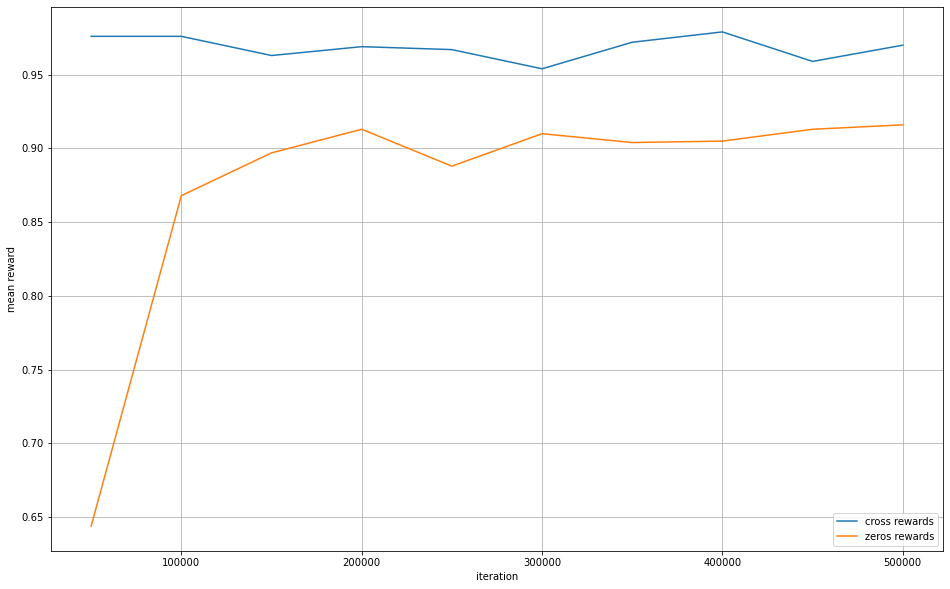

In [24]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

policy_cross = {}
policy_zeros = {}

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
tree, iterations, rewards_cross, rewards_zeros = train_mcts(env, 500_000, policy_cross, policy_zeros)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iteration 50000, cross reward: 0.943, zeros reward: 0.644
Iteration 100000, cross reward: 0.939, zeros reward: 0.889
Iteration 150000, cross reward: 0.949, zeros reward: 0.91
Iteration 200000, cross reward: 0.946, zeros reward: 0.906
Iteration 250000, cross reward: 0.952, zeros reward: 0.923
Iteration 300000, cross reward: 0.937, zeros reward: 0.919
Iteration 350000, cross reward: 0.932, zeros reward: 0.908
Iteration 400000, cross reward: 0.95, zeros reward: 0.901
Iteration 450000, cross reward: 0.954, zeros reward: 0.919
Iteration 500000, cross reward: 0.949, zeros reward: 0.916


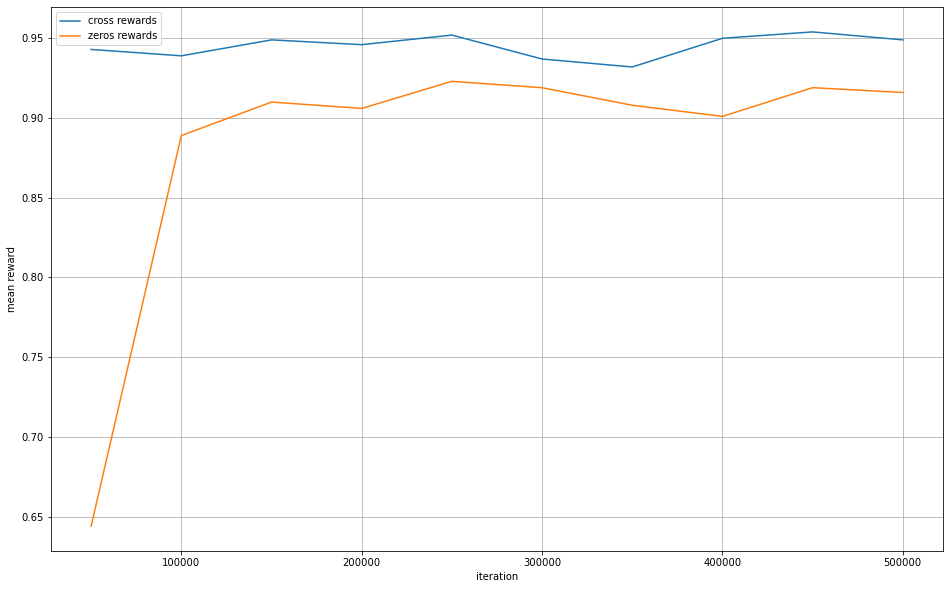

In [25]:
N_ROWS, N_COLS, N_WINS = 3, 3, 3

with open(f"{N_ROWS}_q_policy_cross.json") as f:
    policy_cross = json.load(f)
with open(f"{N_ROWS}_q_policy_zeros.json") as f:
    policy_zeros = json.load(f)

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
tree, iterations, rewards_cross, rewards_zeros = train_mcts(env, 500_000, policy_cross, policy_zeros)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iteration 100000, cross reward: 0.189, zeros reward: 0.025
Iteration 200000, cross reward: 0.17, zeros reward: 0.07
Iteration 300000, cross reward: 0.207, zeros reward: 0.076
Iteration 400000, cross reward: 0.216, zeros reward: 0.074
Iteration 500000, cross reward: 0.229, zeros reward: 0.094
Iteration 600000, cross reward: 0.272, zeros reward: 0.076
Iteration 700000, cross reward: 0.291, zeros reward: 0.052
Iteration 800000, cross reward: 0.222, zeros reward: 0.101
Iteration 900000, cross reward: 0.243, zeros reward: 0.071
Iteration 1000000, cross reward: 0.29, zeros reward: 0.088


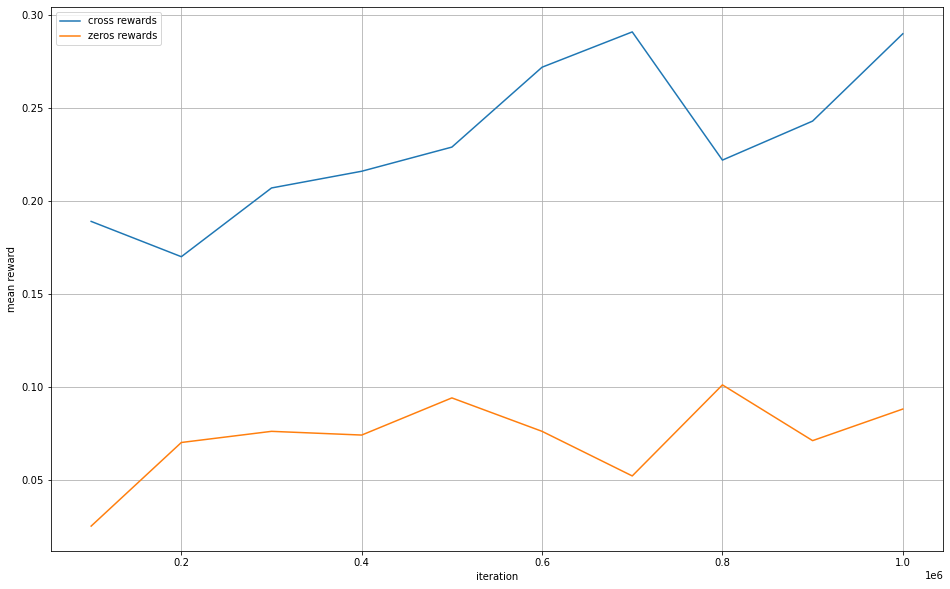

In [26]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

policy_cross = {}
policy_zeros = {}

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
tree, iterations, rewards_cross, rewards_zeros = train_mcts(env, 10_00_000, policy_cross, policy_zeros)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

Iteration 1000000, cross reward: 0.244, zeros reward: 0.048
Iteration 2000000, cross reward: 0.321, zeros reward: 0.113
Iteration 3000000, cross reward: 0.287, zeros reward: 0.12
Iteration 4000000, cross reward: 0.332, zeros reward: 0.103
Iteration 5000000, cross reward: 0.363, zeros reward: 0.148
Iteration 6000000, cross reward: 0.403, zeros reward: 0.143
Iteration 7000000, cross reward: 0.407, zeros reward: 0.1
Iteration 8000000, cross reward: 0.422, zeros reward: 0.151
Iteration 9000000, cross reward: 0.407, zeros reward: 0.166
Iteration 10000000, cross reward: 0.43, zeros reward: 0.176


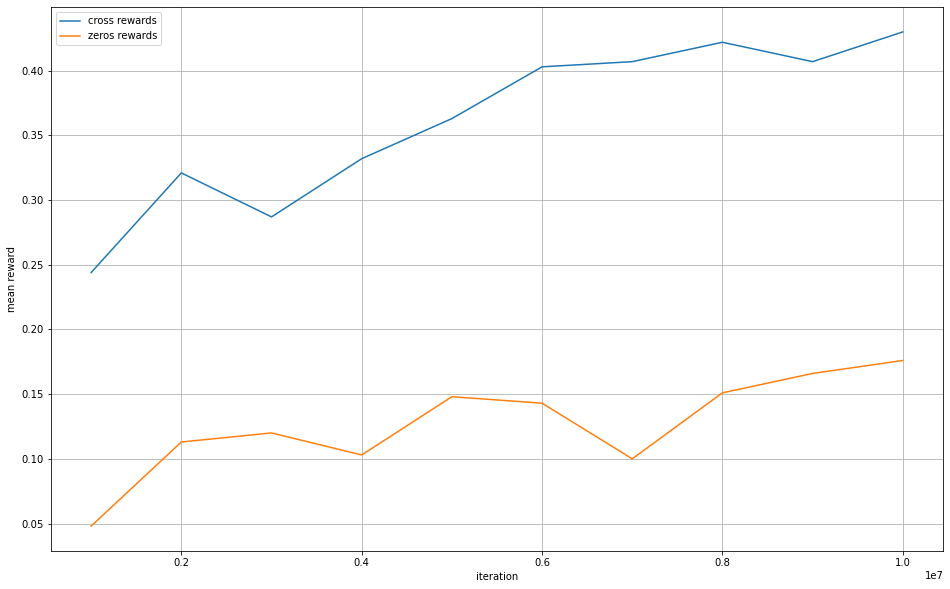

In [27]:
N_ROWS, N_COLS, N_WINS = 4, 4, 4

with open(f"{N_ROWS}_q_policy_cross.json") as f:
    policy_cross = json.load(f)
with open(f"{N_ROWS}_q_policy_zeros.json") as f:
    policy_zeros = json.load(f)

env = TicTacToe(N_ROWS, N_COLS, N_WINS)
tree, iterations, rewards_cross, rewards_zeros = train_mcts(env, 10_000_000, policy_cross, policy_zeros)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
ax.plot(iterations, rewards_cross, label="cross rewards")
ax.plot(iterations, rewards_zeros, label="zeros rewards")
ax.set_xlabel("iteration")
ax.set_ylabel("mean reward")
ax.legend()
ax.grid(True)

- Q learning хуже всего показывает себя на ходах нулей
- DQN и в особенности Double DQN показали наилучшие результаты и не требует слишком много вычислительных ресурсов, особенно для доски 5х5 (в MCTS и Q learning не хватило памяти)
- MCTS показывает средние результаты, чуть лучше при использовании предобученной политики